# Example for training Spiking CNN on subset of NMNIST digits

## The problem:
Training digit classifier(0-9) on a subset(1000 training and 100 testing) of NMNIST digit spikes recorded using DVS camera. Just chagne the training list to for full NMNIST training.

## Load proper paths for SLAYER Pytorch source modules

In [1]:
import sys, os
CURRENT_TEST_DIR = os.getcwd()
sys.path.append(CURRENT_TEST_DIR + "/../src")

## Load required modules

SLAYER modules are available as `snn`
* The `spike-layer` module will be available as `snn.layer`.
* The `yaml-parameter` module will be availabe as `snn.params`.
* The `spike-loss` module will be available as `snn.loss`.
* The `spike-classifier` module will be available as `snn.predict`.
* The `spike-IO` module will be available as `snn.io`.


In [2]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import slayerSNN as snn
from learningStats import learningStats

## Read SNN configuration from yaml file
See the file for all the configuration parameters. This configuration file will be used to describe the SNN. We will ignore the network configuration  describe in the yaml file here.

In [3]:
netParams = snn.params('network.yaml')

## Defne the dataset class
The dataset definition follows standard PyTorch dataset definition.
Internally, it utilizes snn.io modules to read spikes and returns the spike in correct tensor format (CHWT).
* `datasetPath`: the path where the spike files are stored.
* `sampleFile`: the file that contains a list of sample indices and its corresponding clases.
* `samplingTime`: the sampling time (in ms) to bin the spikes.
* `sampleLength`: the length of the sample (in ms)

Note: This is a simple dataset class. A dataset that utilizes the folder hierarchy or xml list is easy to create.

In [4]:
# Dataset definition
class nmnistDataset(Dataset):
	def __init__(self, datasetPath, sampleFile, samplingTime, sampleLength):
		self.path = datasetPath 
		self.samples = np.loadtxt(sampleFile).astype('int')
		self.samplingTime = samplingTime
		self.nTimeBins    = int(sampleLength / samplingTime)

	def __getitem__(self, index):
		inputIndex  = self.samples[index, 0]
		classLabel  = self.samples[index, 1]
		
		inputSpikes = snn.io.read2Dspikes(
						self.path + str(inputIndex.item()) + '.bs2'
						).toSpikeTensor(torch.zeros((2,34,34,self.nTimeBins)),
						samplingTime=self.samplingTime)
		desiredClass = torch.zeros((10, 1, 1, 1))
		desiredClass[classLabel,...] = 1
		return inputSpikes, desiredClass, classLabel
    
	def __len__(self):
		return self.samples.shape[0]

## Define the network
The network definition follows similar style as standard PyTorch network definition, but it utilizes snn modules.

In [5]:
class Network(torch.nn.Module):
	def __init__(self, netParams):
		super(Network, self).__init__()
		# initialize slayer
		slayer = snn.layer(netParams['neuron'], netParams['simulation'])
		self.slayer = slayer
		# define network functions
		self.conv1 = slayer.conv(2, 16, 5, padding=1)
		self.conv2 = slayer.conv(16, 32, 3, padding=1)
		self.conv3 = slayer.conv(32, 64, 3, padding=1)
		self.pool1 = slayer.pool(2)
		self.pool2 = slayer.pool(2)
		self.fc1   = slayer.dense((8, 8, 64), 10)

	def forward(self, spikeInput):
		spikeLayer1 = self.slayer.spike(self.conv1(self.slayer.psp(spikeInput ))) # 32, 32, 16
		spikeLayer2 = self.slayer.spike(self.pool1(self.slayer.psp(spikeLayer1))) # 16, 16, 16
		spikeLayer3 = self.slayer.spike(self.conv2(self.slayer.psp(spikeLayer2))) # 16, 16, 32
		spikeLayer4 = self.slayer.spike(self.pool2(self.slayer.psp(spikeLayer3))) #  8,  8, 32
		spikeLayer5 = self.slayer.spike(self.conv3(self.slayer.psp(spikeLayer4))) #  8,  8, 64
		spikeOut    = self.slayer.spike(self.fc1  (self.slayer.psp(spikeLayer5))) #  10

		return spikeOut

## Initialize the network
* Define the device to run the code on.
* Create network instance.
* Create loss instance.
* Define optimizer module.
* Define training and testing dataloader.
* Cereate instance for learningStats.

In [6]:
# Define the cuda device to run the code on.
# device = torch.device('cuda')
# Use multiple GPU's if available
device = torch.device('cuda:2') # should be the first GPU of deviceIDs
deviceIds = [2, 3]

# Create network instance.
# net = Network(netParams).to(device)
# Split the network to run over multiple GPUs
net = torch.nn.DataParallel(Network(netParams).to(device), device_ids=deviceIds)

# Create snn loss instance.
error = snn.loss(netParams).to(device)

# Define optimizer module.
optimizer = torch.optim.Adam(net.parameters(), lr = 0.01, amsgrad = True)

# Dataset and dataLoader instances.
trainingSet = nmnistDataset(datasetPath =netParams['training']['path']['in'], 
						    sampleFile  =netParams['training']['path']['train'],
						    samplingTime=netParams['simulation']['Ts'],
						    sampleLength=netParams['simulation']['tSample'])
trainLoader = DataLoader(dataset=trainingSet, batch_size=8, shuffle=False, num_workers=4)

testingSet = nmnistDataset(datasetPath  =netParams['training']['path']['in'], 
						    sampleFile  =netParams['training']['path']['test'],
						    samplingTime=netParams['simulation']['Ts'],
						    sampleLength=netParams['simulation']['tSample'])
testLoader = DataLoader(dataset=testingSet, batch_size=8, shuffle=False, num_workers=4)

# Learning stats instance.
stats = learningStats()

## Visualize the spike data
Visualize the first five samples of the dataset.

`snn.io.showTD` should show an animation of the sequence in normal python session.

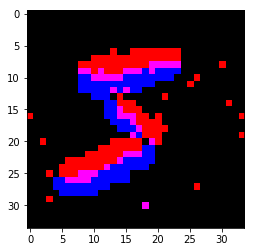

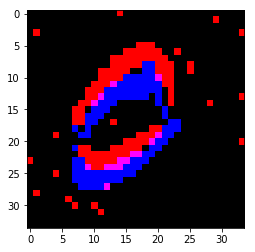

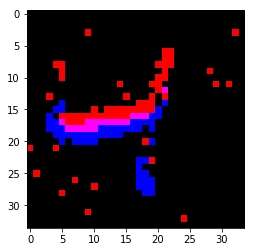

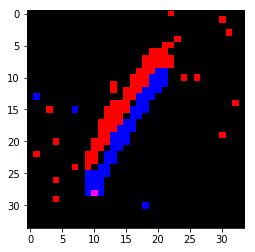

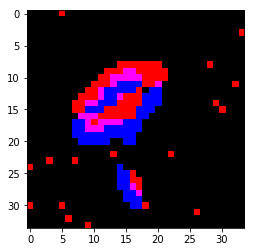

In [7]:
for i in range(5):
	input, target, label = trainingSet[i]
	snn.io.showTD(snn.io.spikeArrayToEvent(input.reshape((2, 34, 34, -1)).cpu().data.numpy()))


# Train the network
Train the network for 100 epochs.

In [8]:
for epoch in range(100):
	# Reset training stats.
	stats.training.reset()
	tSt = datetime.now()
	
	# Training loop.
	for i, (input, target, label) in enumerate(trainLoader, 0):
		# Move the input and target to correct GPU.
		input  = input.to(device)
		target = target.to(device) 
        
		# Forward pass of the network.
		output = net.forward(input)
		
		# Gather the training stats.
		stats.training.correctSamples += torch.sum( snn.predict.getClass(output) == label ).data.item()
		stats.training.numSamples     += len(label)
        
		# Calculate loss.
		loss = error.numSpikes(output, target)
        
		# Reset gradients to zero.
		optimizer.zero_grad()
        
		# Backward pass of the network.
		loss.backward()
        
		# Update weights.
		optimizer.step()

		# Gather training loss stats.
		stats.training.lossSum += loss.cpu().data.item()

		# Display training stats. (Suitable for normal python implementation)
		# stats.print(epoch, i, (datetime.now() - tSt).total_seconds())
	
    # Update training stats.
	stats.training.update()
	# Reset testing stats.
	stats.testing.reset()
	
	# Testing loop.
	# Same steps as Training loops except loss backpropagation and weight update.
	for i, (input, target, label) in enumerate(testLoader, 0):
		input  = input.to(device)
		target = target.to(device) 
		
		output = net.forward(input)

		stats.testing.correctSamples += torch.sum( snn.predict.getClass(output) == label ).data.item()
		stats.testing.numSamples     += len(label)

		loss = error.numSpikes(output, target)
		stats.testing.lossSum += loss.cpu().data.item()
		# stats.print(epoch, i)
	
	# Update testing stats.
	stats.testing.update()
	if epoch%10==0:  stats.print(epoch, timeElapsed=(datetime.now() - tSt).total_seconds())


Epoch :          0,   54188.7760 ms elapsed
loss = 12.459       (min = 12.459      )  	accuracy = 0.101      (max = 0.101     )
loss = 7.4125       (min = 7.4125      )  	accuracy = 0.04       (max = 0.04      )

Epoch :         10,   54446.5260 ms elapsed
loss = 2.7208       (min = 2.7208      )  	accuracy = 0.716      (max = 0.716     )
loss = 3.4074       (min = 3.3913      )  	accuracy = 0.52       (max = 0.52      )

Epoch :         20,   54006.9910 ms elapsed
loss = 0.88611      (min = 0.88611     )  	accuracy = 0.963      (max = 0.963     )
loss = 2.6045       (min = 2.6045      )  	accuracy = 0.62       (max = 0.68      )

Epoch :         30,   53572.0090 ms elapsed
loss = 0.44578      (min = 0.44578     )  	accuracy = 0.992      (max = 0.992     )
loss = 3.0707       (min = 2.6045      )  	accuracy = 0.55       (max = 0.68      )

Epoch :         40,   53697.1220 ms elapsed
loss = 0.28003      (min = 0.26189     )  	accuracy = 0.997      (max = 0.998     )
loss = 3.0216      

## Plot the Results

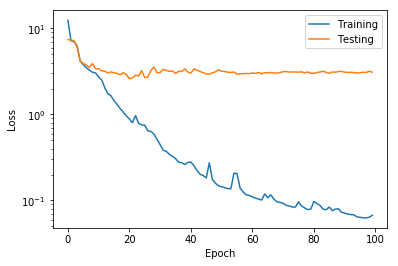

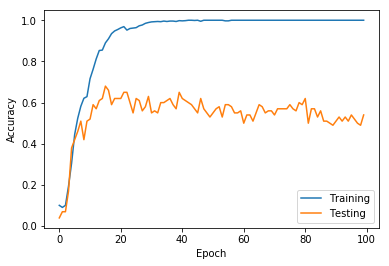

In [9]:
plt.figure(1)
plt.semilogy(stats.training.lossLog, label='Training')
plt.semilogy(stats.testing .lossLog, label='Testing')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.figure(2)
plt.plot(stats.training.accuracyLog, label='Training')
plt.plot(stats.testing .accuracyLog, label='Testing')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()